**Intel Scene Classification Challenge**

In [0]:
!ls

adc.json				    train
sample_data				    train.csv
scene_classification_sample_submission.csv  train_scene_classification.zip
test_scene_classification.csv


**Importing Libraries**

In [0]:
import pandas as pd 
import numpy as np
import os 
import keras 
import matplotlib.pyplot as plt 
import cv2 
import random

from keras.models import Sequential 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras import optimizers 
from keras import metrics 
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


**Loading Data files**

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_scene_classification.csv')

In [0]:
train_df['label'] = train_df['label'].astype(str)

**Helper Functions **

In [0]:
def classDistribution(train_df):
  plt.subplots(figsize = (12, 6))
  ax = train_df['label'].value_counts().plot(kind = 'bar', width = 0.8)
  ax.set_xlabel('Class')
  ax.set_ylabel('No of observations')
  ax.set_title('Class Distribution')
  for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+0.1,p.get_height()), fontsize=15)
  plt.show()
  #plt.savefig('class_distribution.png')
  
  
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
  
def visImageData(title, dataDir, noOfImgs, noOfRows, name):
  sample_imgs = random.sample(os.listdir(dataDir), noOfImgs)
  noOfCols = int(noOfImgs / noOfRows)
  f, ax = plt.subplots(noOfRows, noOfCols, figsize = (20, 10))
  
  for i in range(0, noOfImgs):
    img = cv2.imread(dataDir+sample_imgs[i])
    ax[i//noOfCols, i%noOfCols].imshow(img)
    ax[i//noOfCols, i%noOfCols].axis('off')
    ax[i//noOfCols, i%noOfCols].set_title(sample_imgs[i])
    #print(i//noOfCols, i%noOfCols)
  f.suptitle(title)
  plt.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0, hspace = 0.2)
  plt.show()
  plt.savefig(name)

**Plotting Sample Images**

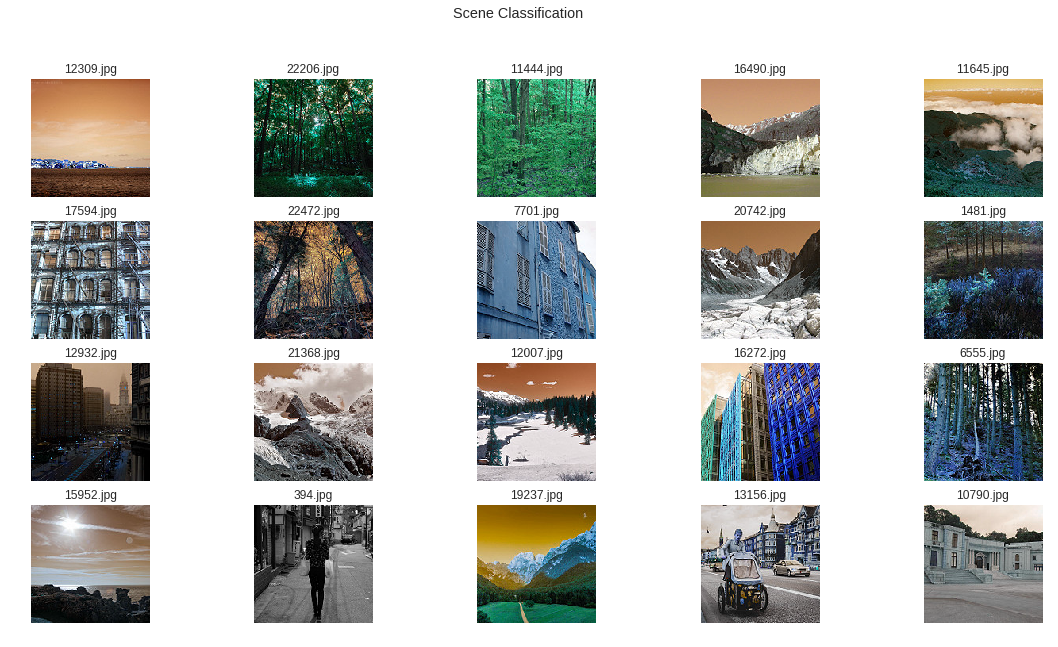

<Figure size 576x396 with 0 Axes>

In [0]:
visImageData('Scene Classification', 'train/', 20, 4, 'scene_sample_imgs.png')


**Class Distribution**

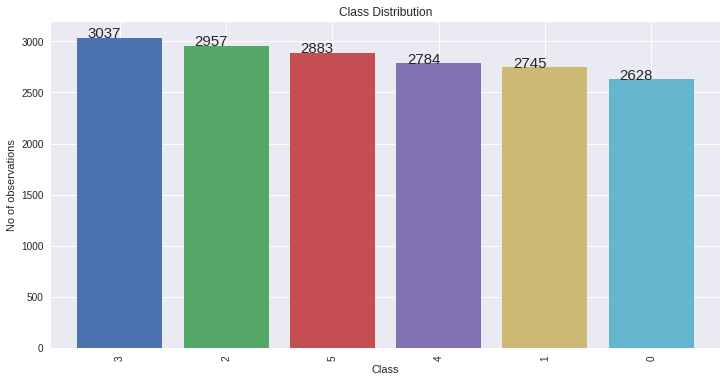

In [0]:
classDistribution(train_df)

**Loading Image Data and Data Augmentation**

In [0]:
datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.15,
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True
)

In [0]:
!mkdir 'preview'

In [0]:
img = cv2.imread('train/1001.jpg')
x = np.asarray(img)
x = x.reshape((1,) + x.shape)

i = 0 
for batch in datagen.flow(x, batch_size = 1, save_to_dir = "preview/", save_prefix = 'img', save_format = 'jpeg'):
  i += 1
  if i > 20:
    break
  

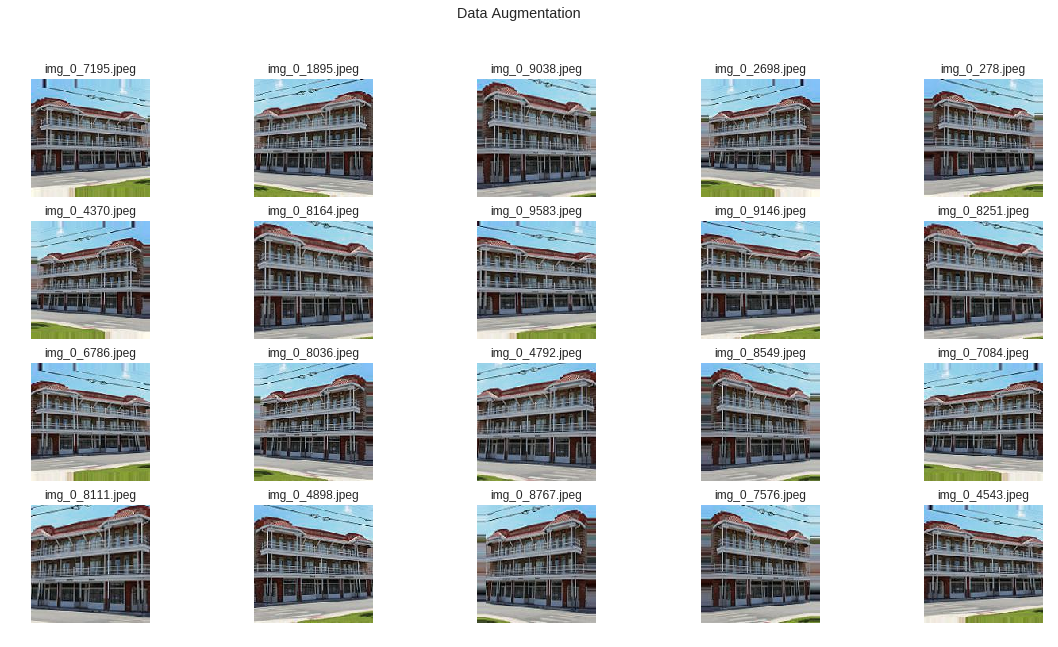

<Figure size 576x396 with 0 Axes>

In [0]:
visImageData('Data Augmentation', 'preview/', 20, 4, 'data_augmentation.png')

In [0]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "train/",
    x_col = 'image_name',
    y_col = 'label',
    subset = 'training',
    seed = 42,
    batch_size = 32, 
    shuffle = True, 
    class_mode = "categorical", 
    target_size = (150, 150) 
)



Found 14479 images belonging to 6 classes.


In [0]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = "train/",
    x_col = 'image_name',
    y_col = 'label',
    subset = 'validation',
    seed = 42,
    batch_size = 32,
    shuffle = True, 
    class_mode = 'categorical',
    target_size = (150, 150)
)


Found 2555 images belonging to 6 classes.


In [0]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df, 
    directory = 'train/',
    x_col = 'image_name',
    y_col = None,
    batch_size = 32, 
    seed = 42,
    shuffle = False, 
    class_mode = None,
    target_size = (150, 150)
)



Found 7301 images.


**Hyperparameters**

In [0]:
img_width , img_height = 150, 150

epochs = 30
batch_size = 32 

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

**Model  ( Pre-trained VGG16)**

In [0]:
from keras import applications
 
base_model = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3) )

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 5s 0us/step


In [0]:
from keras.layers import GlobalAveragePooling2D

x = base_model.output

x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = BatchNormalization()(x)
predictions = Dense(6, activation = 'sigmoid')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras.models import Model

model = Model(inputs = base_model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
for layer in model.layers[:15]:
  layer.trainable = False 
for layer in model.layers[15:]:
  layer.trainable = True
  
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd0722d0ef0> False
<keras.layers.convolutional.Conv2D object at 0x7fd07373c748> False
<keras.layers.convolutional.Conv2D object at 0x7fd07373c828> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd072075eb8> False
<keras.layers.convolutional.Conv2D object at 0x7fd0722c5780> False
<keras.layers.convolutional.Conv2D object at 0x7fd0722e16d8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd0722b9d30> False
<keras.layers.convolutional.Conv2D object at 0x7fd0722b9f60> False
<keras.layers.convolutional.Conv2D object at 0x7fd07288e908> False
<keras.layers.convolutional.Conv2D object at 0x7fd0737b3438> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd0727b1390> False
<keras.layers.convolutional.Conv2D object at 0x7fd0727b16a0> False
<keras.layers.convolutional.Conv2D object at 0x7fd0727d8198> False
<keras.layers.convolutional.Conv2D object at 0x7fd0727db4a8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd073565828>

In [0]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler 
lr_reduce = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, epsilon = 0.0001, patience =  1, verbose = 1)


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
filepath = "vgg16_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max' )

In [0]:
model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

In [0]:
history = model.fit_generator(generator = train_generator, 
                   steps_per_epoch = STEP_SIZE_TRAIN,
                   validation_data = valid_generator, 
                   validation_steps = STEP_SIZE_VALID,
                   callbacks = [lr_reduce, checkpoint],
                   epochs = epochs)

Epoch 1/30
452/452 [==============================] - 148s 328ms/step - loss: 0.1955 - acc: 0.9311 - val_loss: 0.2627 - val_acc: 0.9096

Epoch 00001: val_acc improved from 0.89338 to 0.90963, saving model to vgg16_weights.hdf5
Epoch 2/30
452/452 [==============================] - 147s 325ms/step - loss: 0.1792 - acc: 0.9333 - val_loss: 0.2463 - val_acc: 0.9148

Epoch 00002: val_acc improved from 0.90963 to 0.91478, saving model to vgg16_weights.hdf5
Epoch 3/30
452/452 [==============================] - 146s 324ms/step - loss: 0.1755 - acc: 0.9388 - val_loss: 0.2452 - val_acc: 0.9136

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_acc did not improve from 0.91478
Epoch 4/30
452/452 [==============================] - 144s 319ms/step - loss: 0.1668 - acc: 0.9398 - val_loss: 0.2357 - val_acc: 0.9233

Epoch 00004: val_acc improved from 0.91478 to 0.92326, saving model to vgg16_weights.hdf5
Epoch 5/30
452/452 [==============================

In [0]:
model.evaluate_generator(generator = valid_generator, steps = STEP_SIZE_VALID )

[0.2820320191172631, 0.9072532699876393]

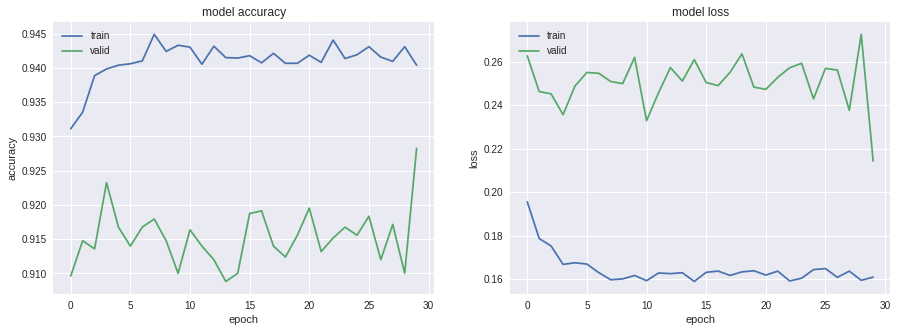

In [0]:
# Accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss'); plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**Model Evaluation**

In [0]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps = test_generator.n/batch_size, verbose = 0)

In [0]:
predicted_class_indices = np.argmax(pred, axis = 1)
predicted_class_indices.shape

(7301,)

In [0]:
labels = (train_generator.class_indices)
labels

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

In [0]:
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

**Submission**

In [0]:
filenames = test_generator.filenames
filenames = filenames
results = pd.DataFrame({"image_name" : filenames, "label" : predictions})
results.to_csv("results.csv", index = False)


In [0]:
results = pd.read_csv("results.csv")
results.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


In [0]:
results.shape

(7301, 2)

In [0]:
from google.colab import files

files.download('results.csv')
#files.download('vgg16_weights.hdf5')
#files.download('model1.h5')
#files.download('model1_results.png')
#files.download('class_distribution.png')